In [1]:
import habitat_sim
import random
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# path_to_mp3d = "path/to/habitat-api/data/scene_datasets/mp3d/"
# folder_content = os.listdir(path_to_mp3d)
# scene_paths = []
# for content in folder_content:
#     full_path = path_to_mp3d + content
#     if os.path.isdir(full_path):
#         full_path = full_path + "/" + content + ".glb"
#         # print(full_path)
#         scene_paths.append(full_path)
        
# print("Total number of scenes:", len(scene_paths))
# test_scene = scene_paths[1]
# print("Scene to be used:", test_scene)

test_scene = "/path/to/_semantic.ply"

sim_settings = {
    "width": 256,  # Spatial resolution of the observations    
    "height": 256,
    "scene": test_scene,  # Scene path
    "default_agent": 0,  
    "sensor_height": 1.5,  # Height of sensors in meters
    "color_sensor": True,  # RGB sensor
    "semantic_sensor": True,  # Semantic sensor
    "depth_sensor": True,  # Depth sensor
    "seed": 1,
}

# Simulator config

In [3]:
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene.id = settings["scene"]
    
    # Note: all sensors must have the same resolution
    sensors = {
        "color_sensor": {
            "sensor_type": habitat_sim.SensorType.COLOR,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "depth_sensor": {
            "sensor_type": habitat_sim.SensorType.DEPTH,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },
        "semantic_sensor": {
            "sensor_type": habitat_sim.SensorType.SEMANTIC,
            "resolution": [settings["height"], settings["width"]],
            "position": [0.0, settings["sensor_height"], 0.0],
        },  
    }
    
    sensor_specs = []
    for sensor_uuid, sensor_params in sensors.items():
        if settings[sensor_uuid]:
            sensor_spec = habitat_sim.SensorSpec()
            sensor_spec.uuid = sensor_uuid
            sensor_spec.sensor_type = sensor_params["sensor_type"]
            sensor_spec.resolution = sensor_params["resolution"]
            sensor_spec.position = sensor_params["position"]

            sensor_specs.append(sensor_spec)
            
    # Here you can specify the amount of displacement in a forward action and the turn angle
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "move_backward": habitat_sim.agent.ActionSpec(
            "move_backward", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "move_right": habitat_sim.agent.ActionSpec(
            "move_right", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "move_left": habitat_sim.agent.ActionSpec(
            "move_left", habitat_sim.agent.ActuationSpec(amount=0.25)
        ),
        "turn_left": habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=15.0)
        ),
        "turn_right": habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=15.0)
        ),
        "look_up": habitat_sim.agent.ActionSpec(
            "look_up", habitat_sim.agent.ActuationSpec(amount=1)
        ),
        "look_down": habitat_sim.agent.ActionSpec(
            "look_down", habitat_sim.agent.ActuationSpec(amount=1)
        ),
    }
    
    return habitat_sim.Configuration(sim_cfg, [agent_cfg])

cfg = make_cfg(sim_settings)
sim = habitat_sim.Simulator(cfg)

W0707 12:36:51.824942 25259 simulator.py:167] Could not find navmesh /home/cengerkin/Desktop/habitat-full/habitat-api/data/scene_datasets/mp3d/testing/new/region0_orig_semantic.navmesh, no collision checking will be done


# Scene semantic annotations

In [4]:
def print_scene_recur(scene, limit_output=10):
    print(f"House has {len(scene.levels)} levels, {len(scene.regions)} regions and {len(scene.objects)} objects")
    print(f"House center:{scene.aabb.center} dims:{scene.aabb.sizes}")
    
    count = 0
    for level in scene.levels:
        print(
            f"Level id:{level.id}, center:{level.aabb.center},"
            f" dims:{level.aabb.sizes}"
        )
        for region in level.regions:
            print(
                f"Region id:{region.id}, category:{region.category.name()},"
                f" center:{region.aabb.center}, dims:{region.aabb.sizes}"
            )
            for obj in region.objects:
                print(
                    f"Object id:{obj.id}, category:{obj.category.name()},"
                    f" center:{obj.aabb.center}, dims:{obj.aabb.sizes}"
                )
                count += 1
                if count >= limit_output:
                    return None

# Print semantic annotation information (id, category, bounding box details) 
# about levels, regions and objects in a hierarchical fashion
scene = sim.semantic_scene
print_scene_recur(scene)

House has 0 levels, 0 regions and 0 objects
House center:[0. 0. 0.] dims:[-inf -inf -inf]


In [5]:
random.seed(sim_settings["seed"])
sim.seed(sim_settings["seed"])

# Set agent state
agent = sim.initialize_agent(sim_settings["default_agent"])
agent_state = habitat_sim.AgentState()
agent_state.position = np.array([-2.55085,3.54118,9.5677]) # TODO: Change here as desired
# agent_state.position # TODO: Change here as desired
agent.set_state(agent_state)

# Get agent state
agent_state = agent.get_state()
print("agent_state: position", agent_state.position, "rotation", agent_state.rotation)

agent_state: position [-2.55085  3.54118  9.5677 ] rotation quaternion(1, 0, 0, 0)


In [6]:
from PIL import Image
from habitat_sim.utils.common import d3_40_colors_rgb

def display_sample(rgb_obs, semantic_obs, depth_obs):
    """Plot RGB, Semantic and Depth images"""
    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")
    
    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")
    
    depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")

    arr = [rgb_img, semantic_img, depth_img]
    titles = ['rgb', 'semantic', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

# Take random actions and display sensor data

['move_forward', 'move_backward', 'move_right', 'move_left', 'turn_left', 'turn_right', 'look_up', 'look_down']
action move_right


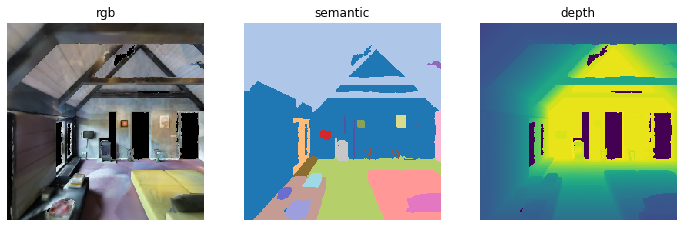

action move_backward


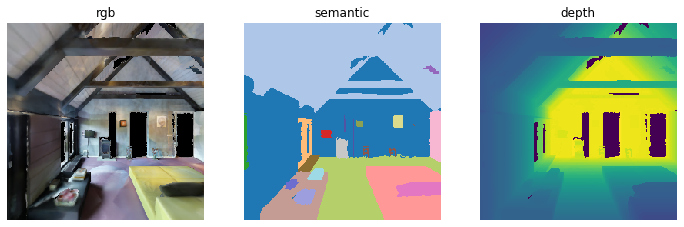

action turn_left


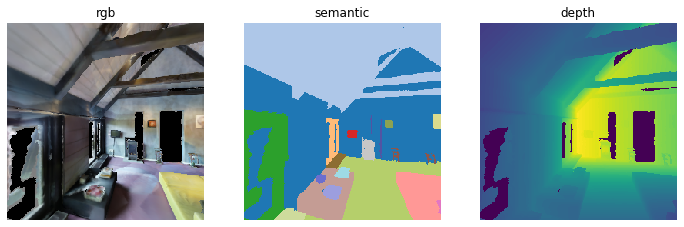

action move_backward


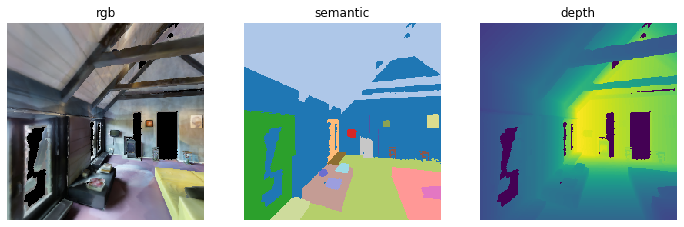

action look_down


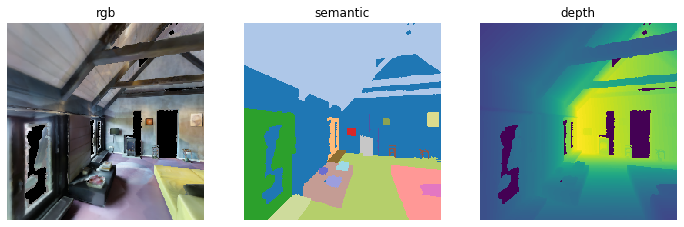

In [7]:
total_frames = 0
action_names = list(
    cfg.agents[
        sim_settings["default_agent"]
    ].action_space.keys()
)

print(action_names)

max_frames = 5

while total_frames < max_frames:
    action = random.choice(action_names)
    print("action", action)
    observations = sim.step(action)
    rgb = observations["color_sensor"]
    semantic = observations["semantic_sensor"]
    depth = observations["depth_sensor"]
    
    display_sample(rgb, semantic, depth)
    
    total_frames += 1

# Take Specified Actions

Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


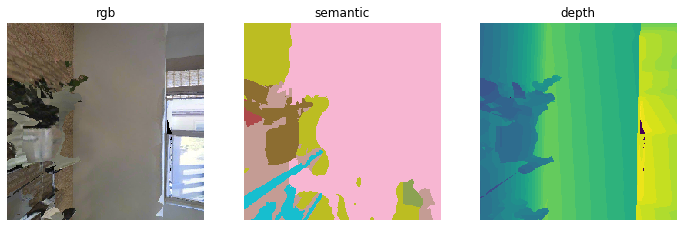

Agent state, Position: [0.25       0.18682313 0.25      ] Rotation: quaternion(0.991444885730743, 0, 0.130526199936867, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


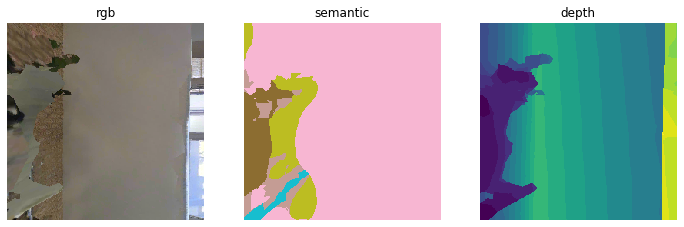

Agent state, Position: [0.18529522 0.18682313 0.00851855] Rotation: quaternion(0.991444885730743, 0, 0.130526199936867, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


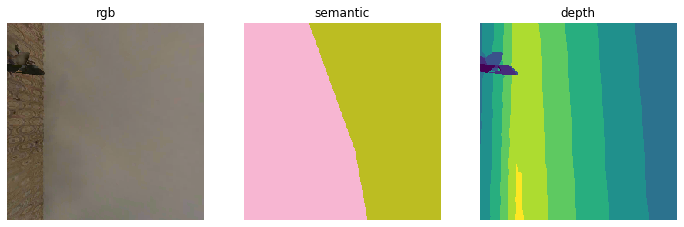

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.991444885730743, 0, 0.130526199936867, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


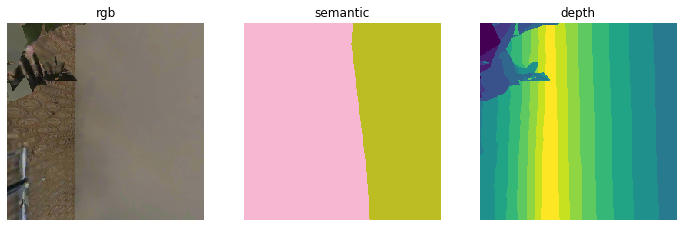

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.965925872325897, 0, 0.258819073438644, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


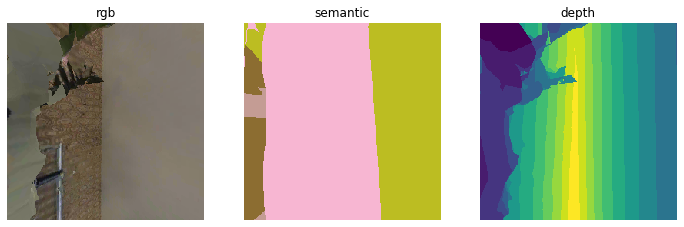

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.923879504203796, 0, 0.382683426141739, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


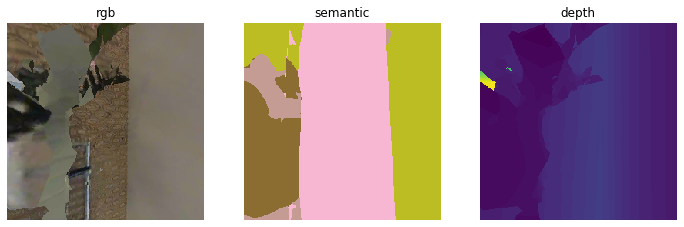

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.866025447845459, 0, 0.5, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


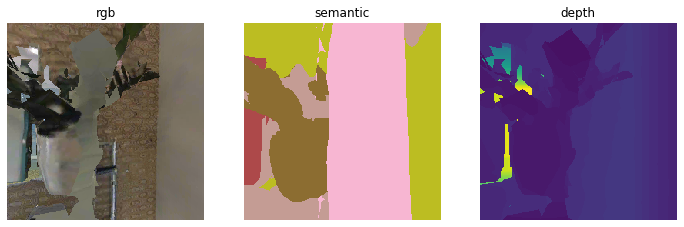

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.79335343837738, 0, 0.608761429786682, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


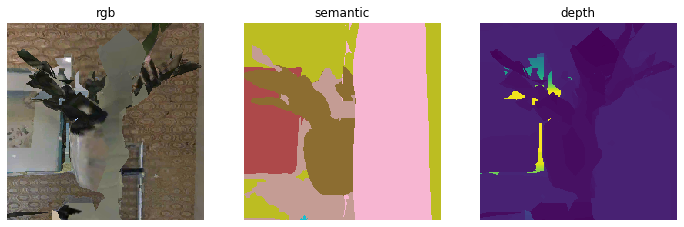

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.707106828689575, 0, 0.70710676908493, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


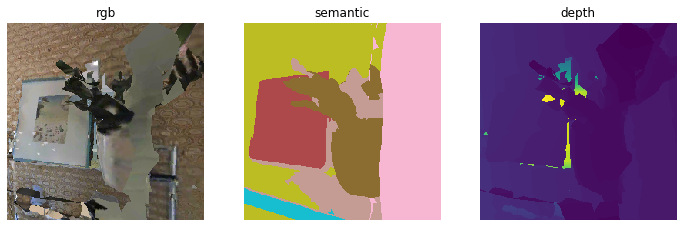

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.608761489391327, 0, 0.793353319168091, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


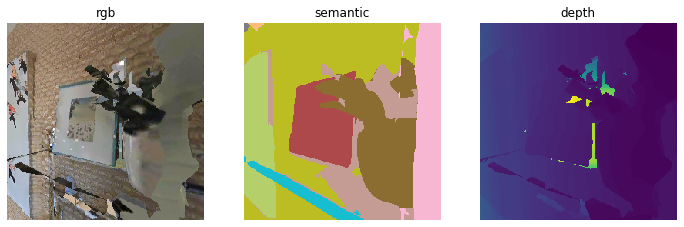

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.500000059604645, 0, 0.866025388240814, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


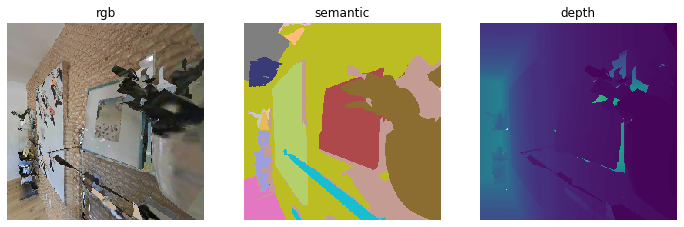

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.382683515548706, 0, 0.923879563808441, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


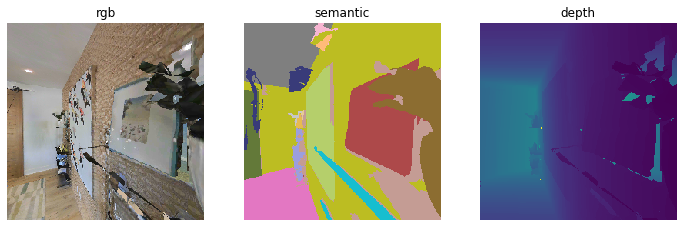

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.258819103240967, 0, 0.965925812721252, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


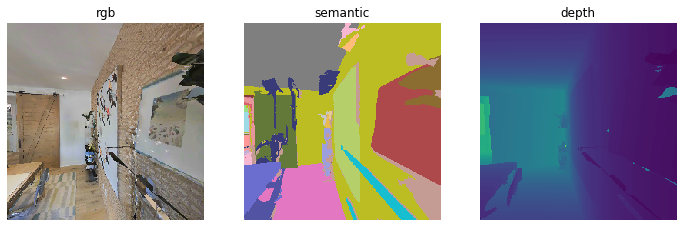

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(0.130526259541512, 0, 0.991444885730743, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


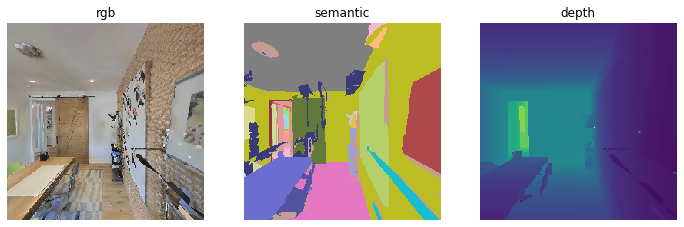

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


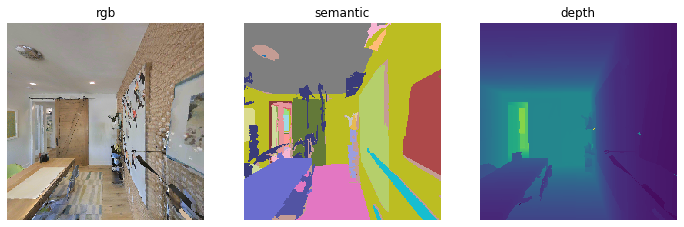

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


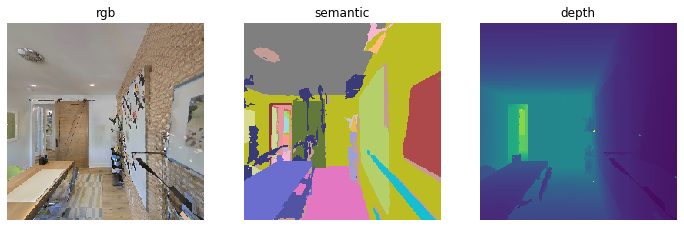

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


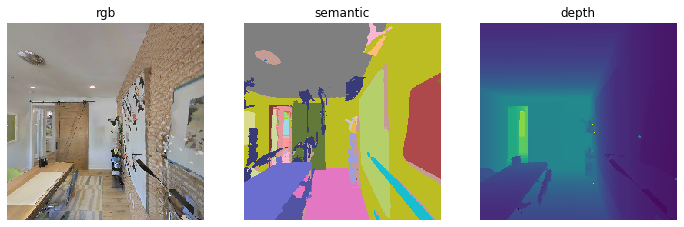

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


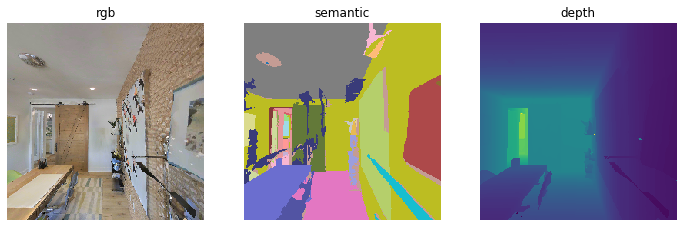

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


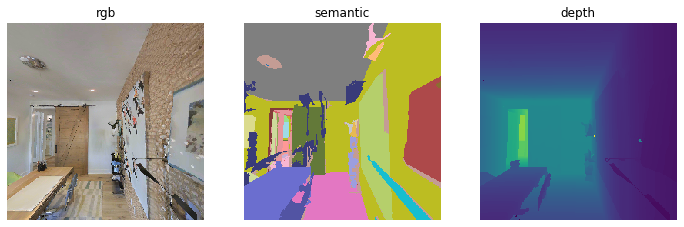

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


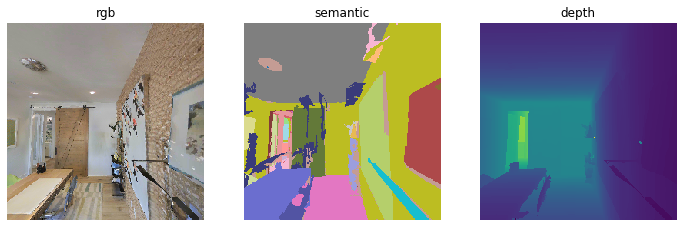

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


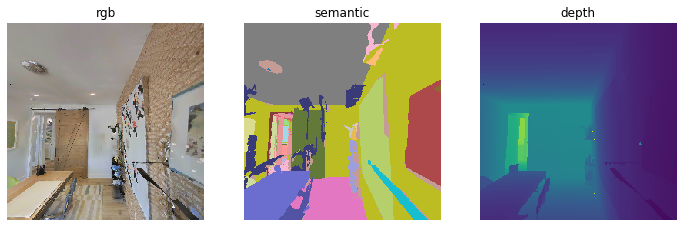

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


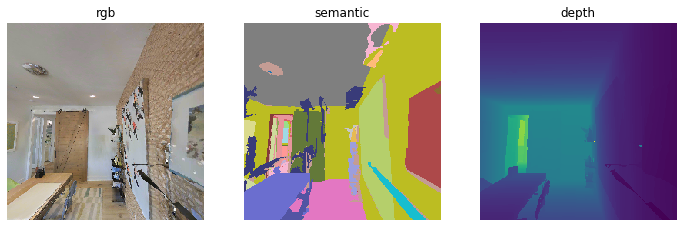

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


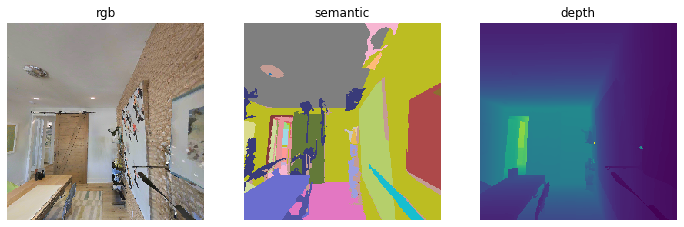

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


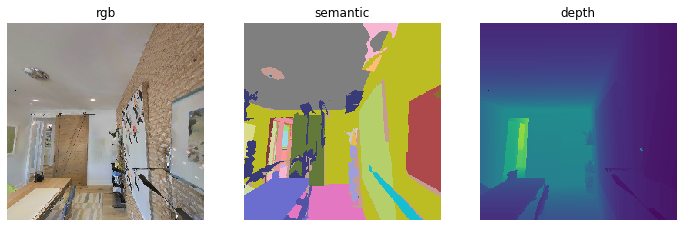

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


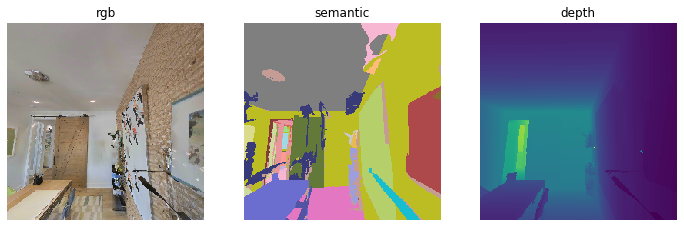

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


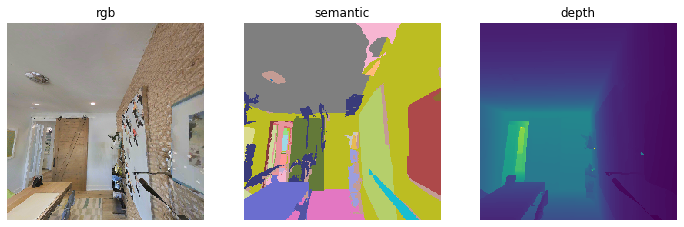

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


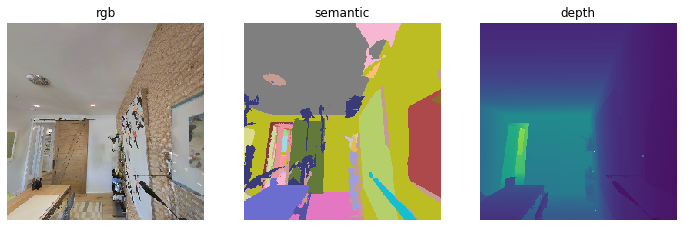

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


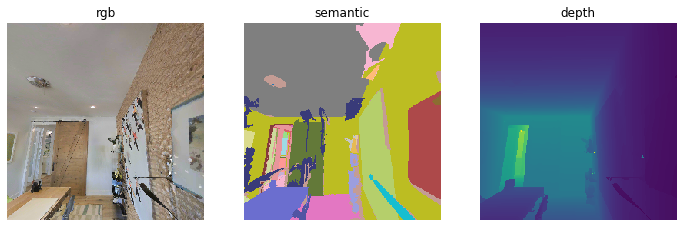

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


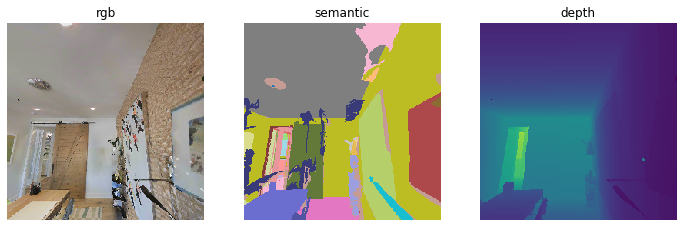

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 3
Action look_up


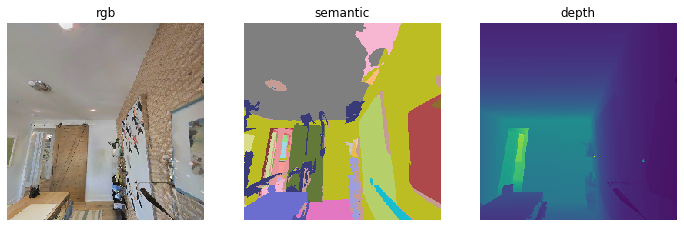

Agent state, Position: [ 0.12059046  0.18682313 -0.2329629 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


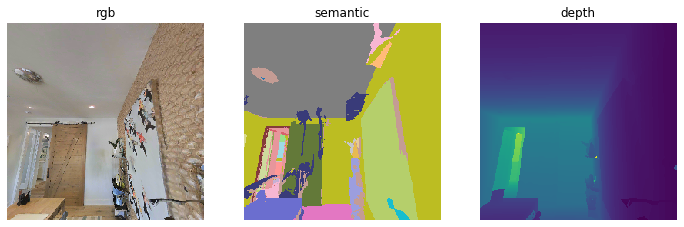

Agent state, Position: [0.12059043 0.18682313 0.01703709] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


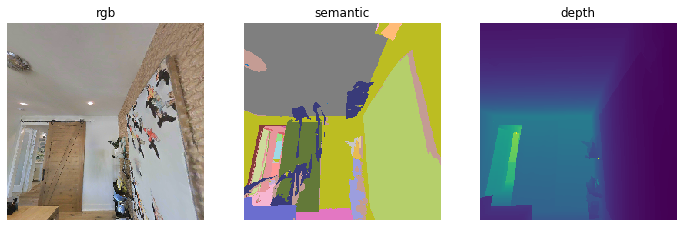

Agent state, Position: [0.1205904  0.18682313 0.2670371 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


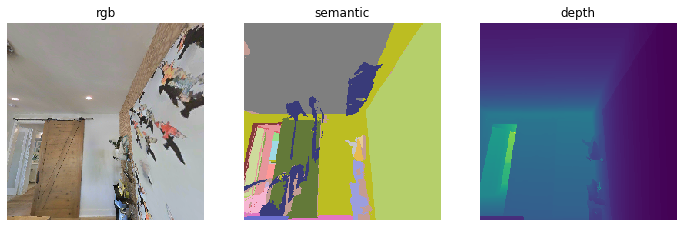

Agent state, Position: [0.12059037 0.18682313 0.5170371 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


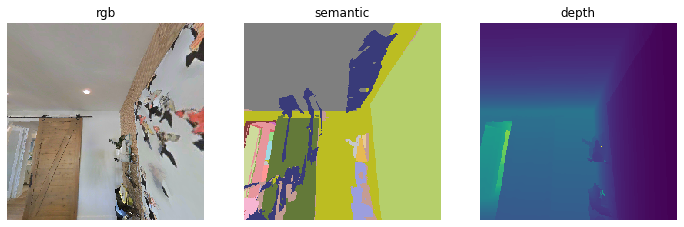

Agent state, Position: [0.12059034 0.18682313 0.7670371 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


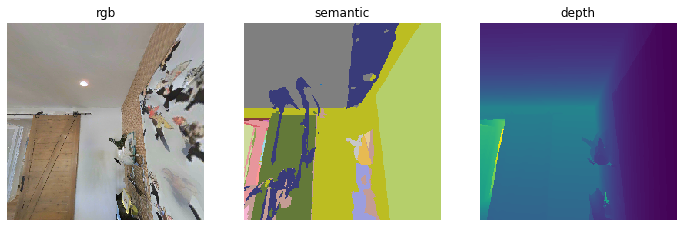

Agent state, Position: [0.12059031 0.18682313 1.0170372 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


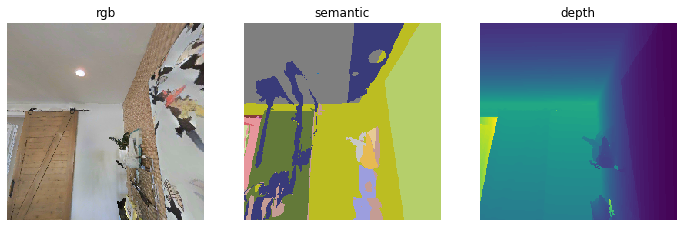

Agent state, Position: [0.12059028 0.18682313 1.2670372 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


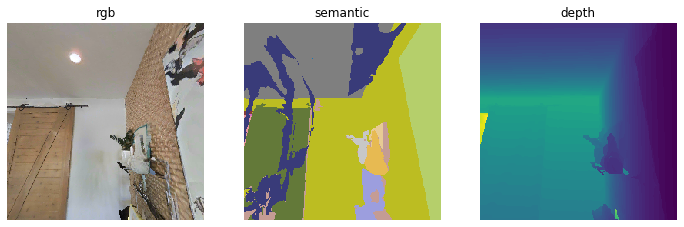

Agent state, Position: [0.12059025 0.18682313 1.5170372 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


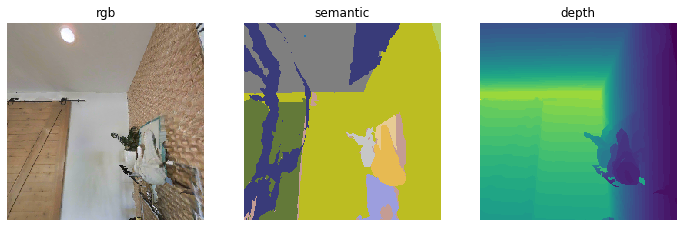

Agent state, Position: [0.12059022 0.18682313 1.7670372 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


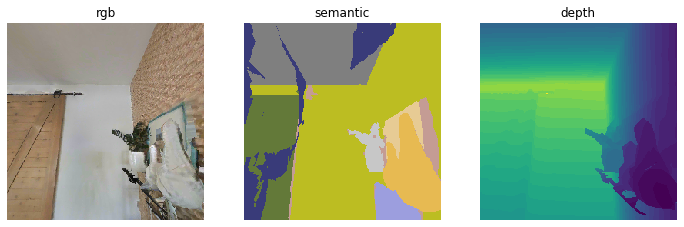

Agent state, Position: [0.12059019 0.18682313 2.0170372 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


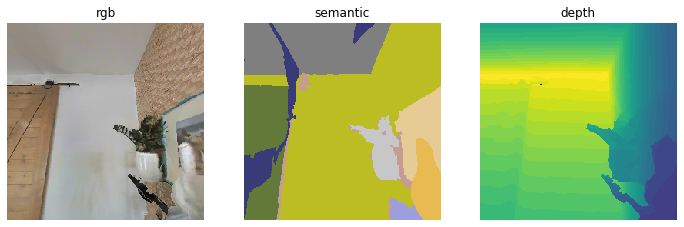

Agent state, Position: [0.12059016 0.18682313 2.2670372 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


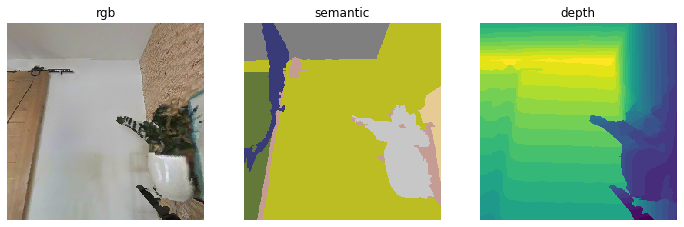

Agent state, Position: [0.12059013 0.18682313 2.5170372 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: w
Action move_forward


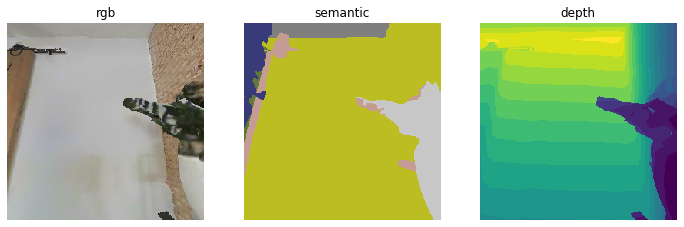

Agent state, Position: [0.1205901  0.18682313 2.7670372 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: a
Action move_left


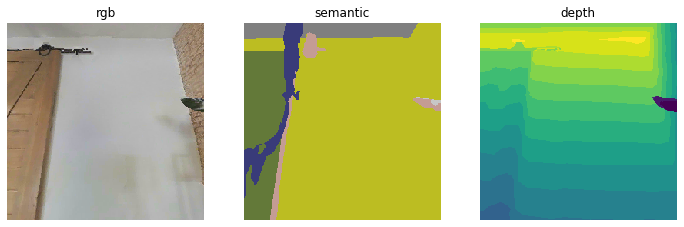

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(5.96046376699633e-08, 0, 1, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


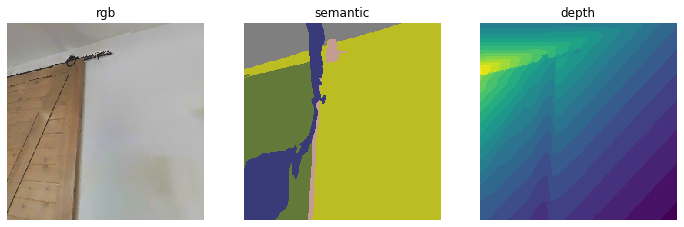

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.130526140332222, 0, 0.991444885730743, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


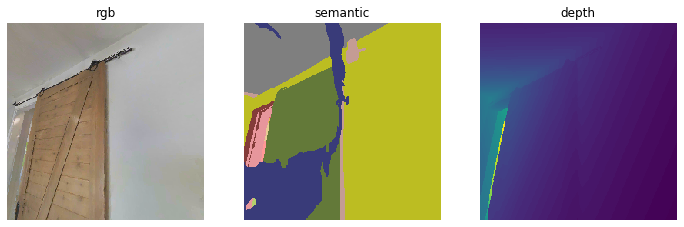

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.258819013834, 0, 0.965925872325897, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


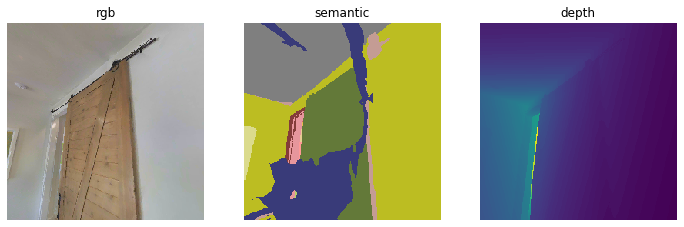

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.382683426141739, 0, 0.923879623413086, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


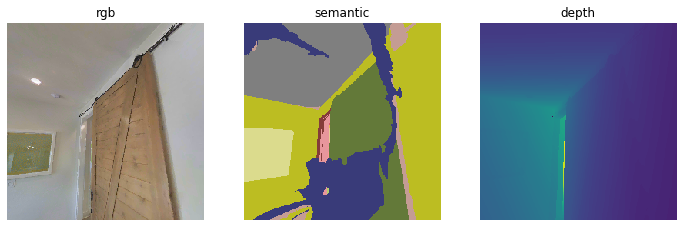

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.499999940395355, 0, 0.866025447845459, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


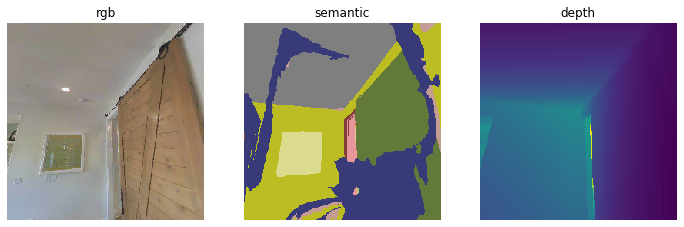

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.608761370182037, 0, 0.79335343837738, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


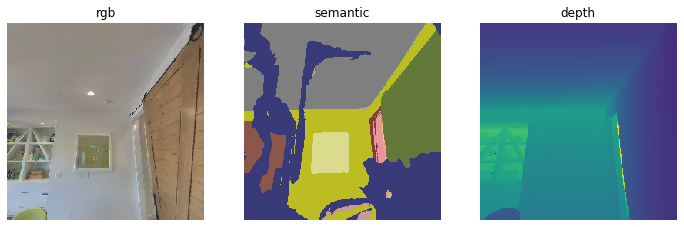

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.70710676908493, 0, 0.70710688829422, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


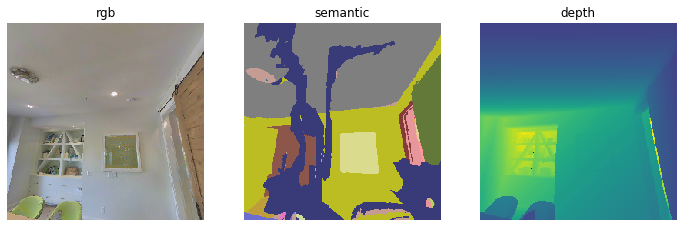

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.793353319168091, 0, 0.608761548995972, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


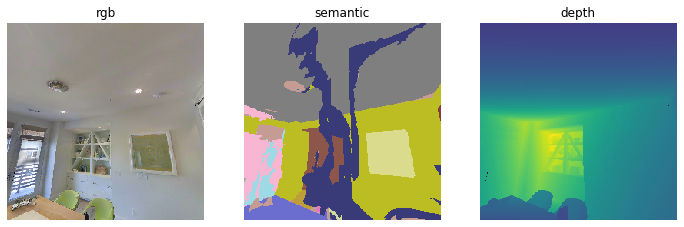

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.866025388240814, 0, 0.50000011920929, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


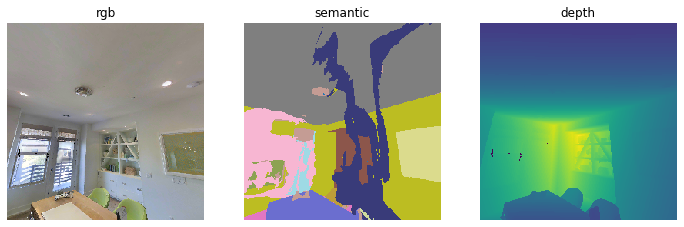

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.923879444599152, 0, 0.382683515548706, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


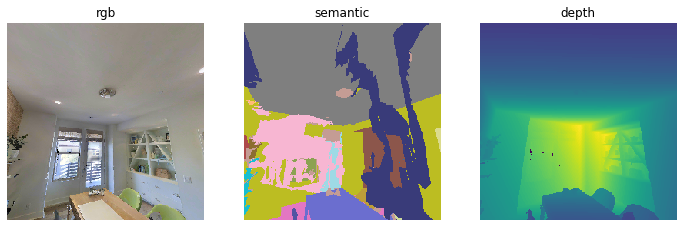

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.965925812721252, 0, 0.258819133043289, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


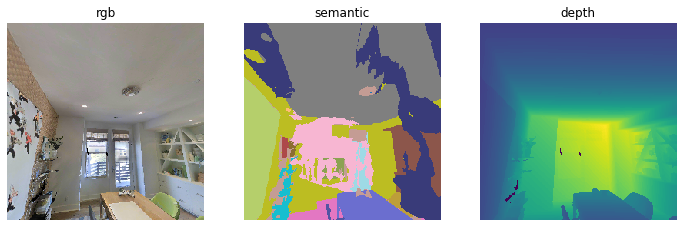

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-0.991444885730743, 0, 0.130526289343834, 0)
Press a key [W/A/S/D/1/2/3/4]: 1
Action turn_left


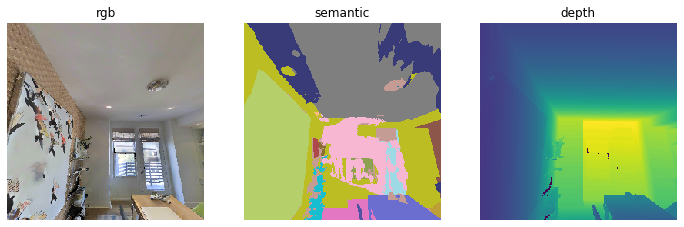

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-1, 0, 8.94069600576586e-08, 0)
Press a key [W/A/S/D/1/2/3/4]: 4
Action look_down


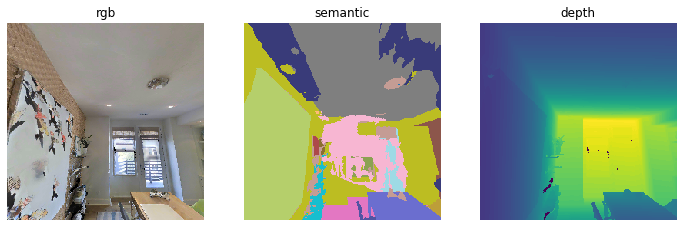

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-1, 0, 8.94069600576586e-08, 0)
Press a key [W/A/S/D/1/2/3/4]: 4
Action look_down


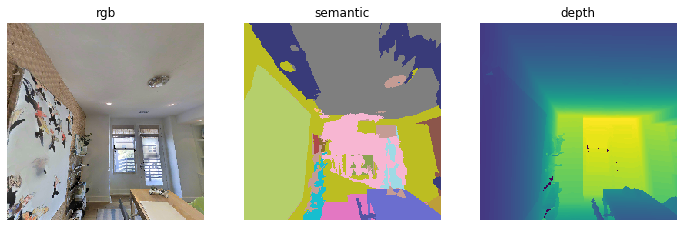

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-1, 0, 8.94069600576586e-08, 0)
Press a key [W/A/S/D/1/2/3/4]: 4
Action look_down


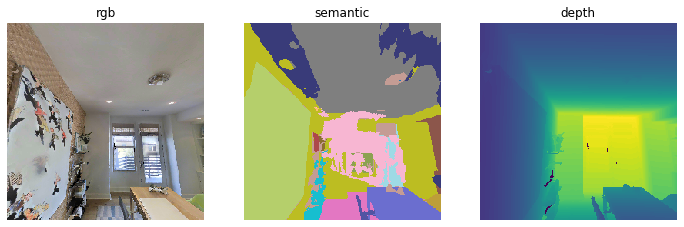

Agent state, Position: [0.3705901  0.18682313 2.7670372 ] Rotation: quaternion(-1, 0, 8.94069600576586e-08, 0)
Press a key [W/A/S/D/1/2/3/4]: 
ord() expected a character, but string of length 0 found


In [8]:
from IPython.display import clear_output
action_names = list(
    cfg.agents[
        sim_settings["default_agent"]
    ].action_space.keys()
)

action_map = {
    49: "turn_left",
    50: "turn_right",
    51: "look_up",
    52: "look_down",
    **dict.fromkeys((87, 119), "move_forward"),
    **dict.fromkeys((65, 97), "move_left"),
    **dict.fromkeys((83, 115), "move_backward"),
    **dict.fromkeys((68, 100), "move_right")
}

run = True

while run:
    try:
        button = ord(input("Press a key [W/A/S/D/1/2/3/4]: "))
        #clear_output(): flush output
        action = action_map[button]
        print("Action", action)
        observations = sim.step(action)
        rgb = observations["color_sensor"]
        semantic = observations["semantic_sensor"]
        depth = observations["depth_sensor"]

        display_sample(rgb, semantic, depth)
        
        agent_state = agent.get_state()
        print("Agent state, Position:", agent_state.position, "Rotation:", agent_state.rotation)

    except Exception as e:
        print(e)
        run = False